In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('/content/drive/MyDrive/data.csv', encoding='ISO-8859-1')


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.shape

(541909, 8)

In [6]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [7]:
# حذف رکوردهای بدون CustomerID
df = df.dropna(subset=['CustomerID'])
# تبدیل فرمت CustomerID به int
df['CustomerID'] = df['CustomerID'].astype(int)
# حذف تراکنش‌های بازگشتی یا منفی
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# ایجاد ستون TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# تبدیل تاریخ به datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


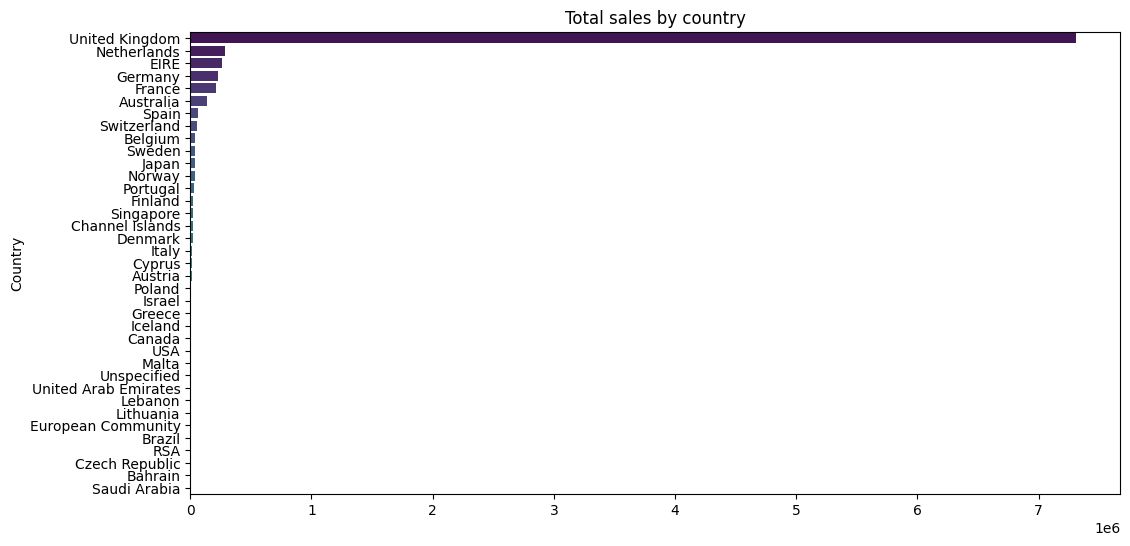

In [8]:
# محاسبه TotalSales برای هر سطر
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# مجموع فروش بر اساس کشور
sales_by_country = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=sales_by_country.values, y=sales_by_country.index, palette='viridis')
plt.title('Total sales by country')
plt.show()

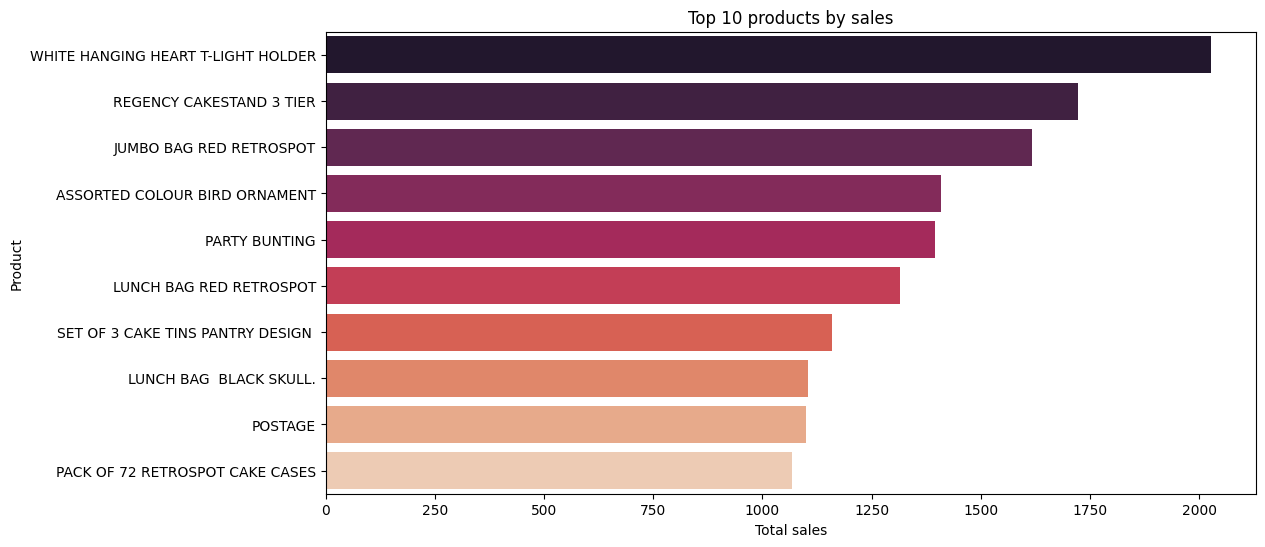

In [9]:
top_10_products = df['Description'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_10_products.values, y=top_10_products.index, palette='rocket')
plt.title('Top 10 products by sales')
plt.xlabel('Total sales')
plt.ylabel('Product')
plt.show()

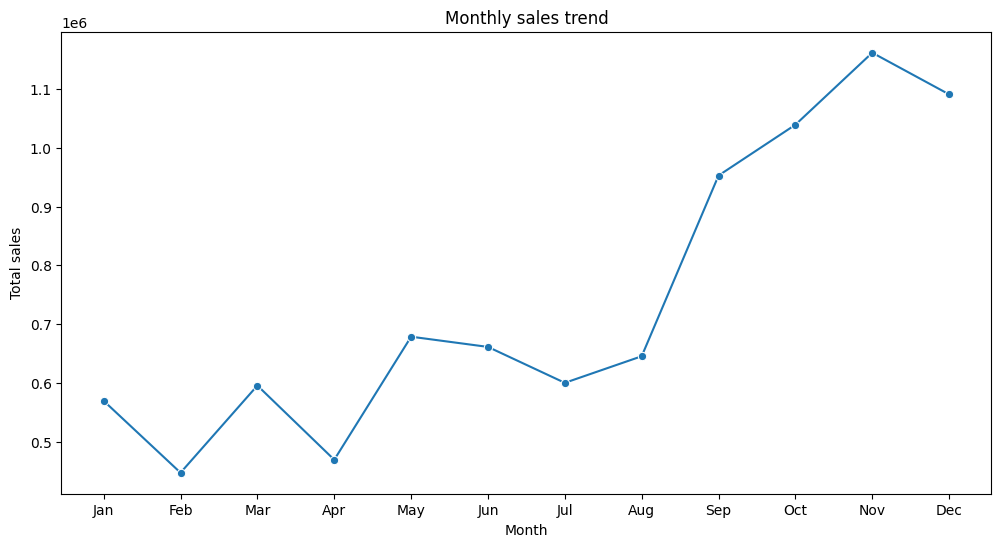

In [10]:
# استخراج ماه از تاریخ
df['Month'] = df['InvoiceDate'].dt.month

# فروش ماهانه
monthly_sales = df.groupby('Month')['TotalSales'].sum()
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Monthly sales trend')
plt.xlabel('Month')
plt.ylabel('Total sales')
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

In [11]:
# محاسبه RFM
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique', # Frequency
    'TotalSales': 'sum' # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# نمرهدهی RFM
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=False, duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=False, duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=False, duplicates='drop')
# ترکیب نمرات
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


# دستهبندی مشتریان
bins = [0, 4, 7, 10, 13]  # مرزهای دسته‌بندی
labels = [
    'نیازمند توجه',
    'در خطر از دست رفتن',
    'وفادار قدیمی',
    'ستاره‌ها'
]
rfm['Segment'] = pd.cut(
    rfm['RFM_Score'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [12]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment,Segment
0,12346,326,1,77183.60,4,0,4,8,404,وفادار قدیمی
1,12347,2,7,4310.00,0,3,4,7,034,در خطر از دست رفتن
2,12348,75,4,1797.24,3,2,3,8,323,وفادار قدیمی
3,12349,19,1,1757.55,1,0,3,4,103,نیازمند توجه
4,12350,310,1,334.40,4,0,1,5,401,در خطر از دست رفتن


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [14]:
rfm.head()
rfm.describe()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.00000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460,1.984555,0.970954,2.00000,4.955509
std,1721.808492,100.014169,7.697998,8989.230441,1.414537,1.168957,1.41454,2.081597
min,12346.000000,1.000000,1.000000,3.750000,0.000000,0.000000,0.00000,0.000000
25%,13813.250000,18.000000,1.000000,307.415000,1.000000,0.000000,1.00000,4.000000
50%,15299.500000,51.000000,2.000000,674.485000,2.000000,0.000000,2.00000,5.000000
75%,16778.750000,142.000000,5.000000,1661.740000,3.000000,2.000000,3.00000,7.000000
max,18287.000000,374.000000,209.000000,280206.020000,4.000000,3.000000,4.00000,11.000000


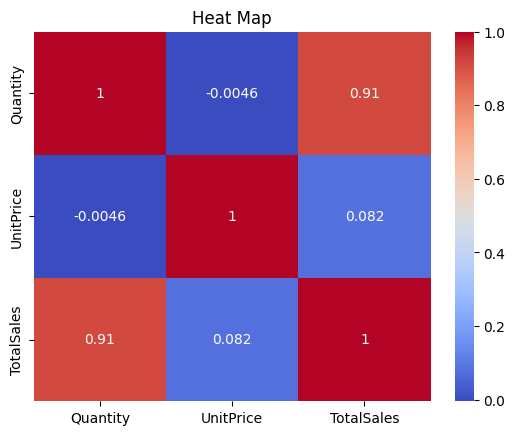

In [15]:
corr = df[['Quantity', 'UnitPrice', 'TotalSales']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heat Map')
plt.show()

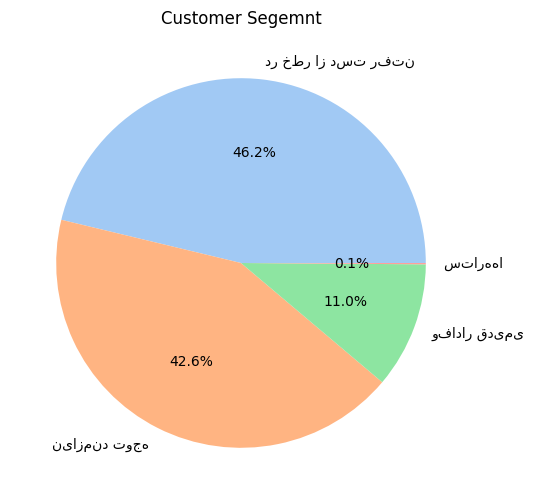

In [16]:
plt.figure(figsize=(10,6))
rfm['Segment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Customer Segemnt')
plt.ylabel('')
plt.show()

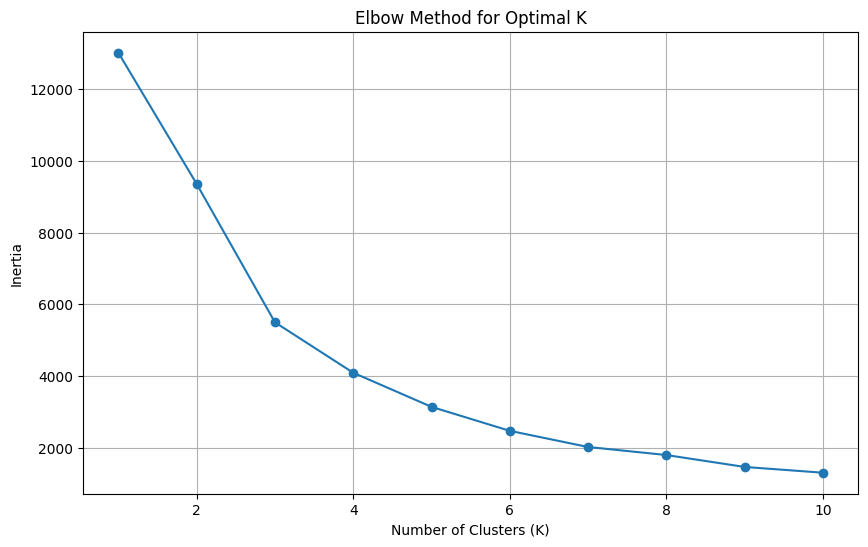

In [17]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


Cluster Analysis (Mean RFM Values and Count per Cluster):
         MeanRecency  MeanFrequency  MeanMonetary  Count
Cluster                                                 
0             247.11           1.58        631.42   1082
1              41.45           4.67       1855.94   3230
2               6.04          66.42      85904.35     26


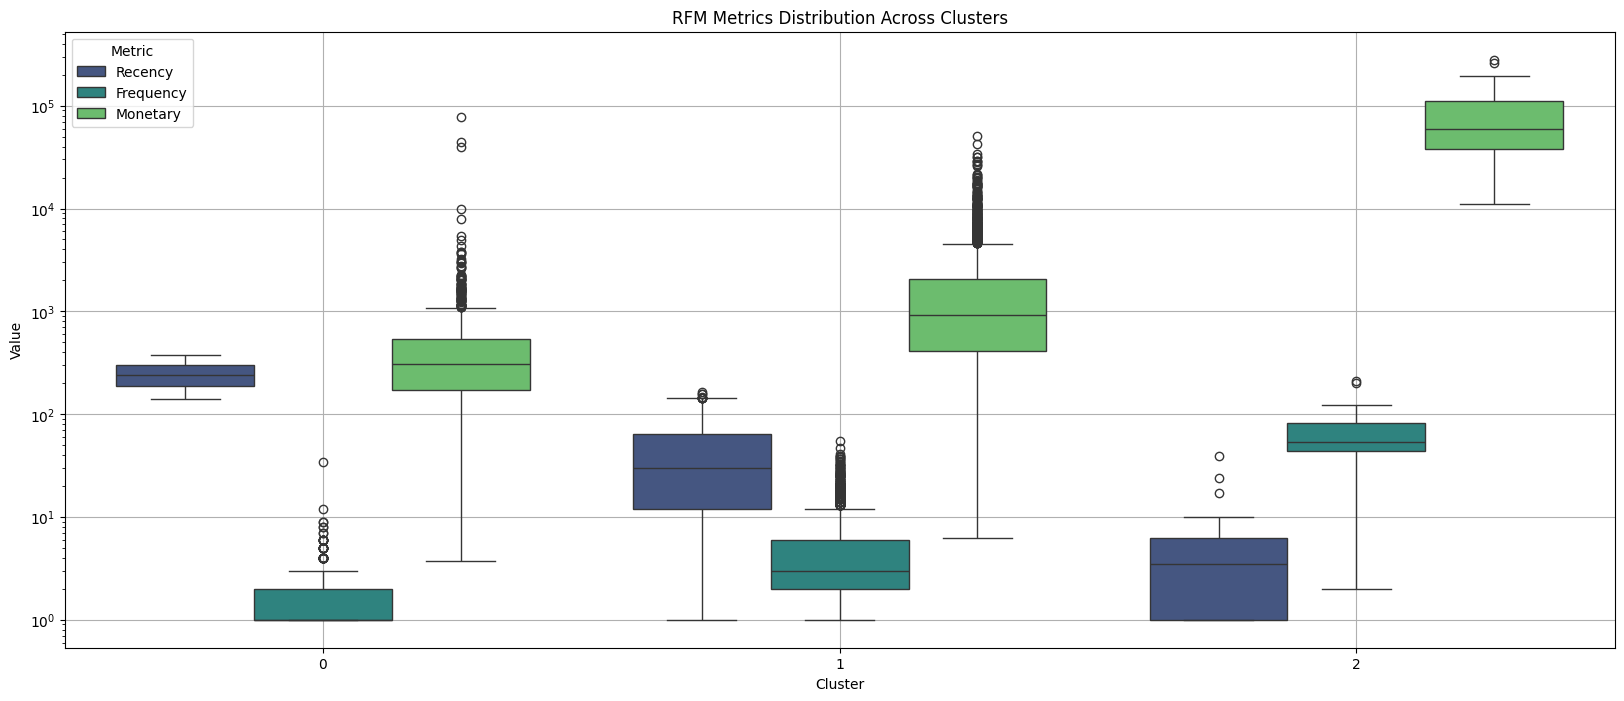


RFM data with cluster assignments saved to 'rfm_with_clusters.csv'


In [18]:

# Apply K-Means clustering with optimal K (chosen as 3 from elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters by calculating the mean of RFM values for each cluster
cluster_analysis = rfm.groupby('Cluster').agg(
    MeanRecency=('Recency', 'mean'),
    MeanFrequency=('Frequency', 'mean'),
    MeanMonetary=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).round(2)

print("\nCluster Analysis (Mean RFM Values and Count per Cluster):")
print(cluster_analysis)

# Visualize the clusters (e.g., pairplot of RFM values colored by cluster)
rfm_melted = pd.melt(rfm.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name='Metric',
                    value_name='Value')

plt.figure(figsize=(20, 8))
sns.boxplot(x='Cluster', y='Value', hue='Metric', data=rfm_melted, palette='viridis')
plt.title('RFM Metrics Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.yscale('log') # Use log scale for better visualization of Monetary
plt.grid(True)
plt.show()
# Save the RFM data with cluster assignments to a CSV file
rfm.to_csv('rfm_with_clusters.csv', index=True)
print("\nRFM data with cluster assignments saved to 'rfm_with_clusters.csv'")